In [111]:
import numpy as np
from NonlinearController.systems import FullUnbalancedDisc
import deepSI
from matplotlib import pyplot as plt
from NonlinearController.models import *
from NonlinearController.lpv_embedding import *

In [209]:
sim_len = 20; dt = 0.1; sim_times = np.arange(sim_len)*dt
system = FullUnbalancedDisc(dt=dt)
# u = np.ones(sim_len)*3
u = deepSI.deepSI.exp_design.multisine(sim_len,pmax=sim_len//2-1)*1
data = system.apply_experiment(deepSI.System_data(u=u))

nx = 2; ny = 1; nu = 1; nz = ny+nx
f_ode = odeCasADiUnbalancedDisc()
expr_rk4, x0_cas, u0_cas = RK4(f_ode, dt=dt)
Jfx = Function("Jfx", [x0_cas, u0_cas], [jacobian(expr_rk4,x0_cas)])
Jfu = Function("Jfu", [x0_cas, u0_cas], [jacobian(expr_rk4,u0_cas)])


In [210]:
expr_output = vertcat(x0_cas[1])
lpv_A, lpv_B, lpv_C = CasADi_velocity_lpv_embedding(expr_rk4, expr_output, x0_cas, u0_cas, n_stages=15, numerical_method=1)

In [211]:
log_x_MMVT = np.zeros((sim_len,nx))

x0 = data.y[0,:]; x_1 = data.y[0,:]; dx0 = x0 - x_1
u0 = data.u[0]; u_1 = 0; du0 = np.array(u0 - u_1)[np.newaxis][np.newaxis]

log_x_MMVT[0,:] = x0.copy()

for i in range(sim_len-1):
    A = Jfx(x0, u0)
    A_ext = np.zeros((nz,nz)); A_ext[:ny,:ny] = np.eye(ny); A_ext[:ny,nx:] = 1; A_ext[ny:,ny:] = A
    B = Jfu(x0, u0)
    B_ext = np.zeros((nz,nu)); B_ext[ny:,:] = B

    z0 = np.hstack((x_1[1],dx0))[np.newaxis].T

    z1 = A_ext @ z0 + B_ext @ du0

    dx0 = z1[ny:,0].copy()
    y_1 = z1[:ny,0].copy()

    x_1 = x0.copy(); x0 = x_1 + dx0
    u_1 = u0.copy(); u0 = data.u[i+1]; du0 = np.array(u0 - u_1)[np.newaxis][np.newaxis]

    log_x_MMVT[i+1,:] = x0.copy()

    # x0 = data.y[i+1,:]


In [212]:
log_x_FTC = np.zeros((sim_len,nx))

x0 = data.y[0,:]; x_1 = data.y[0,:]; dx0 = x0 - x_1
u0 = data.u[0]; u_1 = 0; du0 = np.array(u0 - u_1)[np.newaxis][np.newaxis]

log_x_FTC[0,:] = x0.copy()

for i in range(sim_len-1):
    A = lpv_A(x_1,dx0,u_1,du0)
    A_ext = np.zeros((nz,nz)); A_ext[:ny,:ny] = np.eye(ny); A_ext[:ny,nx:] = 1; A_ext[ny:,ny:] = A
    B = lpv_B(x_1,dx0,u_1,du0)
    B_ext = np.zeros((nz,nu)); B_ext[ny:,:] = B

    z0 = np.hstack((x_1[1],dx0))[np.newaxis].T

    z1 = A_ext @ z0 + B_ext @ du0

    dx0 = z1[ny:,0].copy()
    y_1 = z1[:ny,0].copy()

    x_1 = x0.copy(); x0 = x_1 + dx0
    u_1 = u0.copy(); u0 = data.u[i+1]; du0 = np.array(u0 - u_1)[np.newaxis][np.newaxis]

    log_x_FTC[i+1,:] = x0.copy()

    # x0 = data.y[i+1,:]


0.15937567389304566, 0.0001961633592312076


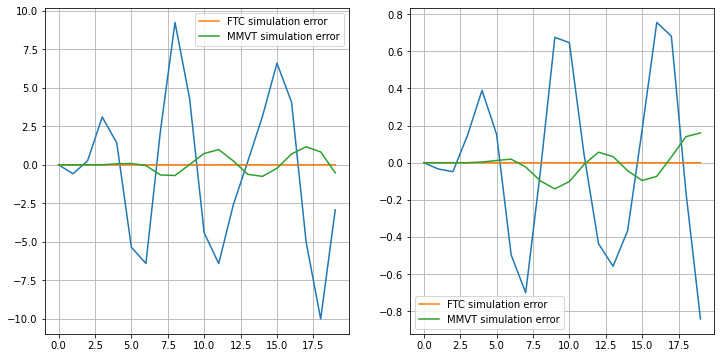

In [213]:
nrmse_mmvt = np.sqrt(np.sum(np.square(log_x_MMVT[:,1] - data.y[:,1]))/len(data.y[:,1])) / np.std(data.y[:,1])
nrmse_ftc = np.sqrt(np.sum(np.square(log_x_FTC[:,1] - data.y[:,1]))/len(data.y[:,1])) / np.std(data.y[:,1])
print(str(nrmse_mmvt) + ", " + str(nrmse_ftc))

fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(data.y[:,0])
plt.plot(log_x_FTC[:,0] - data.y[:,0], label="FTC simulation error")
plt.plot(log_x_MMVT[:,0] - data.y[:,0], label="MMVT simulation error")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(data.y[:,1])
plt.plot(log_x_FTC[:,1] - data.y[:,1], label="FTC simulation error")
plt.plot(log_x_MMVT[:,1] - data.y[:,1], label="MMVT simulation error")
plt.legend()
plt.grid()